# ID5004W AI in Predictive Maintenance, Reliability and Warranty
# Mini Project by Vinu Varshith G
# Kalman Filter vs Particle Filter

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Importing tank-height measurements

In [2]:
Z_true = pd.read_excel('Link 2 Measurements.xlsx')
Z_true_np = np.array(Z_true)

In [3]:
Z_true.describe()

,h1,h2,h3,h4
count,10001.000000,10001.000000,10001.000000,10001.000000
mean,12.264862,12.782324,1.634324,1.409018
std,0.014958,0.006015,0.005699,0.000353
min,12.262968,12.700000,1.633941,1.400000
25%,12.262968,12.783158,1.633941,1.409045
50%,12.262968,12.783158,1.633941,1.409045
75%,12.262968,12.783158,1.633941,1.409045
max,12.444367,12.783158,1.800000,1.409045


In [4]:
Z_true_np.shape

(10001, 4)

# 1.) KF-1 Initializations

In [329]:
# Area of the tank using its diameter
A1 = 28
A2 = 32
A3 = 28
A4 = 32

# Area of the orifice using its diameter
a1 = 0.071
a2 = 0.057
a3 = 0.071
a4 = 0.057

# Time Constants
T1 = 62
T2 = 90
T3 = 23
T4 = 30

# Gammas
gamma1 = 0.7
gamma2 = 0.6

# Constant of proportionality for Voltage-Flow relationship
k1 = 3.33
k2 = 3.35

# Tank height measurement constant for the tanks 1 and 2 only
kc = 0.5

# Gravitation constant
g = 981

# Input Voltages
v1 = 3
v2 = 3


# A, B, H, U
A = np.array([[-1/T1, 0, A3/(A1*T3), 0], [0, -1/T2, 0, A4/(A2*T4)], [0, 0, -1/T3, 0], [0, 0, 0, -1/T4]])
B = np.array([[(gamma1*k1)/A1, 0], [0, (gamma2*k2)/A2], [0, (1-gamma2)*k2/A3], [(1-gamma1)*k1/A4, 0]])
H = np.array([[kc, 0, 0, 0], [0, kc, 0, 0]])
U = np.array([[v1, v2]]).T

# Lists to store
X_posterior_store = []
X_prior_store = []
P_posterior_store = []
P_prior_store = []
Kalman_Gain_store = []
Innovation_store = []
Residue_store = []

# Kalman Filter - using x_posterior_0 = [1, 1, 1, 1].T

In [330]:
# Some filter method specific initializations
X_posterior_0 = np.array([[1, 1, 1, 1]]).T
P_posterior_0 = 1e5*np.eye(4)
Q = 8*np.eye(4)
Q[0,2]=Q[1,3]=Q[2,0]=Q[2,2]=Q[3,1]=Q[3,3]=1
R = 2*np.eye(2)

for iteration in range(10000):
    
   
    # Height prior calculation
    X_prior = A.dot(X_posterior_0) + B.dot(U)
    # Calculating Process noise covariance matrix
    P_prior = (A.dot(P_posterior_0)).dot(A.T) + Q
    #Calculating the Kalman Gain
    Kalman_Gain = (P_prior.dot(H.T)).dot((np.linalg.inv((H.dot(P_prior)).dot(H.T) + R)))
    # Estimating the output voltage for each time step
    V_true = Z_true_np[iteration+1, :2].reshape(-1,1)
    # Calculating the Error between the true and the predicted output voltages
    Error = V_true - H.dot(X_prior)
    
    # Kalman height update step
    X_posterior = X_prior + Kalman_Gain.dot(Error)
    # Kalman process noise covariance update step
    P_posterior = P_prior - (Kalman_Gain.dot(H)).dot(P_prior)
    
    # Storing various values for plotting in lists
    X_posterior_store.append(X_posterior.tolist())
    P_posterior_store.append(np.trace(P_posterior))
    X_prior_store.append(X_prior.tolist())
    P_prior_store.append(np.trace(P_prior))
    Kalman_Gain_store.append(np.trace(Kalman_Gain))
    Innovation_store.append(Error.tolist())
    Residue_store.append((Z_true_np[iteration, :2].reshape(-1,1) - H.dot(X_posterior)).tolist())
    
    # updating the posteriors of X and P for the next time step in the for loop
    X_posterior_0 = X_posterior
    P_posterior_0 = P_posterior
    
    # Algorithm stopping condition
    Threshold = np.linalg.norm((X_prior - X_posterior), 2)
    if (Threshold <= .005):
        print('Exiting the loop...')
        break


# KF-1: Plots

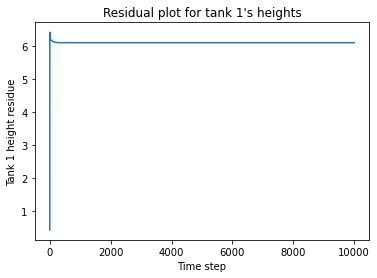

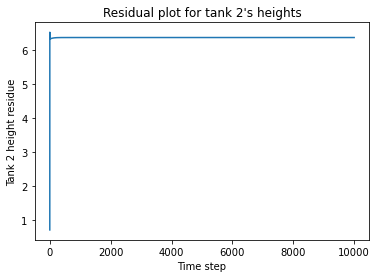

In [331]:
# 1. Residue plots
resid_h1 = [Residue_store[i][0][0] for i in range(10000)]
resid_h2 = [Residue_store[i][1][0] for i in range(10000)]

plt.plot(range(10000), resid_h1)
plt.title("Residual plot for tank 1's heights")
plt.xlabel('Time step')
plt.ylabel('Tank 1 height residue')
plt.show()
plt.plot(range(10000), resid_h2)
plt.title("Residual plot for tank 2's heights")
plt.xlabel('Time step')
plt.ylabel('Tank 2 height residue')
plt.show()

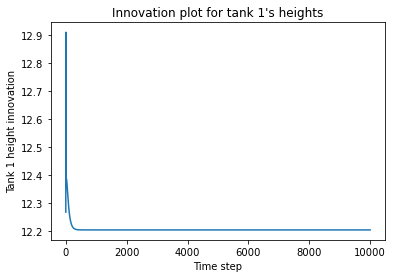

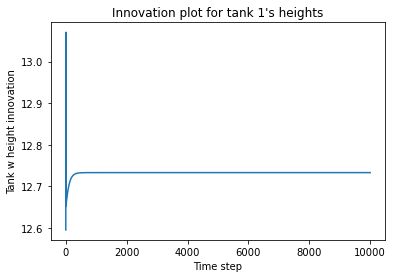

In [332]:
# 2. Innovation plots
innov_h1 = [Innovation_store[i][0][0] for i in range(10000)]
innov_h2 = [Innovation_store[i][1][0] for i in range(10000)]

plt.plot(range(10000), innov_h1)
plt.title("Innovation plot for tank 1's heights")
plt.xlabel('Time step')
plt.ylabel('Tank 1 height innovation')
plt.show()
plt.plot(range(10000), innov_h2)
plt.title("Innovation plot for tank 1's heights")
plt.xlabel('Time step')
plt.ylabel('Tank w height innovation')
plt.show()

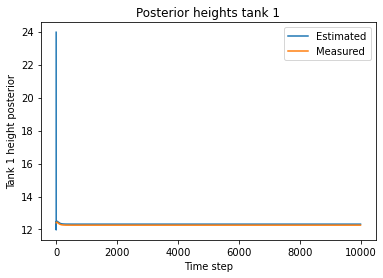

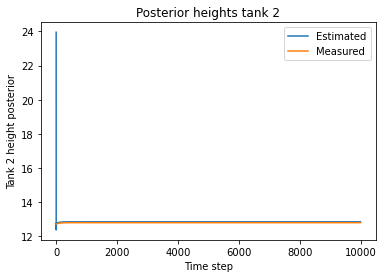

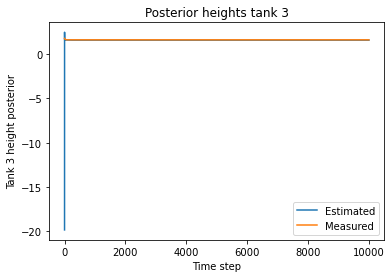

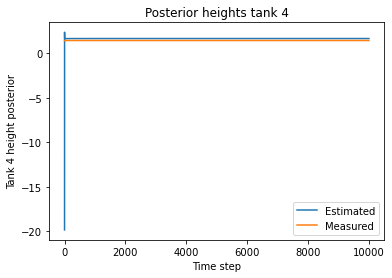

In [333]:
# 3. X_posterior plot
X_posterior_tank1 = [X_posterior_store[i][0][0] for i in range(10000)]
X_posterior_tank2 = [X_posterior_store[i][1][0] for i in range(10000)]
X_posterior_tank3 = [X_posterior_store[i][2][0] for i in range(10000)]
X_posterior_tank4 = [X_posterior_store[i][3][0] for i in range(10000)]

plt.plot(range(10000),X_posterior_tank1, label='Estimated')
plt.plot(range(10000), Z_true_np[1:,0], label='Measured')
plt.title('Posterior heights tank 1')
plt.xlabel('Time step')
plt.ylabel('Tank 1 height posterior')
plt.legend()
plt.show()

plt.plot(range(10000),X_posterior_tank2, label='Estimated')
plt.plot(range(10000), Z_true_np[1:,1], label='Measured')
plt.title('Posterior heights tank 2')
plt.xlabel('Time step')
plt.ylabel('Tank 2 height posterior')
plt.legend()
plt.show()

plt.plot(range(10000),X_posterior_tank3, label='Estimated')
plt.plot(range(10000), Z_true_np[1:,2], label='Measured')
plt.title('Posterior heights tank 3')
plt.xlabel('Time step')
plt.ylabel('Tank 3 height posterior')
plt.legend()
plt.show()

plt.plot(range(10000),X_posterior_tank4, label='Estimated')
plt.plot(range(10000), Z_true_np[1:,3], label='Measured')
plt.title('Posterior heights tank 4')
plt.xlabel('Time step')
plt.ylabel('Tank 4 height posterior')
plt.legend()
plt.show()

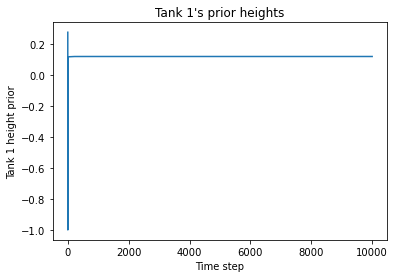

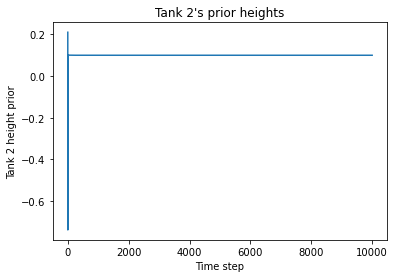

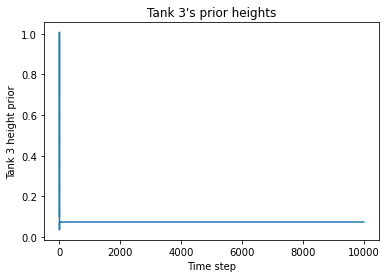

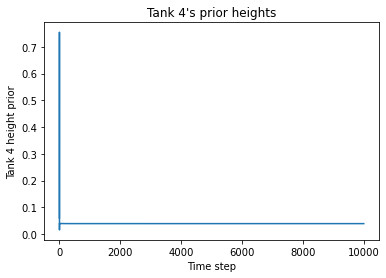

In [334]:
# 4. X_prior plot
X_prior_tank1 = [X_prior_store[i][0][0] for i in range(10000)]
X_prior_tank2 = [X_prior_store[i][1][0] for i in range(10000)]
X_prior_tank3 = [X_prior_store[i][2][0] for i in range(10000)]
X_prior_tank4 = [X_prior_store[i][3][0] for i in range(10000)]

plt.plot(range(10000),X_prior_tank1)
plt.title("Tank 1's prior heights")
plt.xlabel('Time step')
plt.ylabel('Tank 1 height prior')
plt.show()
plt.plot(range(10000),X_prior_tank2)
plt.title("Tank 2's prior heights")
plt.xlabel('Time step')
plt.ylabel('Tank 2 height prior')
plt.show()
plt.plot(range(10000),X_prior_tank3)
plt.title("Tank 3's prior heights")
plt.xlabel('Time step')
plt.ylabel('Tank 3 height prior')
plt.show()
plt.plot(range(10000),X_prior_tank4)
plt.title("Tank 4's prior heights")
plt.xlabel('Time step')
plt.ylabel('Tank 4 height prior')
plt.show()

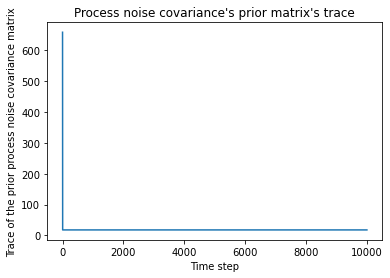

In [335]:
# 5. P_prior matrix's trace plot
P_prior_plot = [P_prior_store[i] for i in range(10000)]

plt.plot(range(10000),P_prior_plot)
plt.title("Process noise covariance's prior matrix's trace")
plt.xlabel('Time step')
plt.ylabel('Trace of the prior process noise covariance matrix')
plt.show()

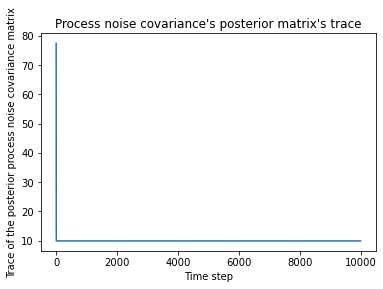

In [336]:
# 6. P_posterior matrix's trace plot
P_posterior_plot = [P_posterior_store[i] for i in range(10000)]

plt.plot(range(10000),P_posterior_plot)
plt.title("Process noise covariance's posterior matrix's trace")
plt.xlabel('Time step')
plt.ylabel('Trace of the posterior process noise covariance matrix')
plt.show()

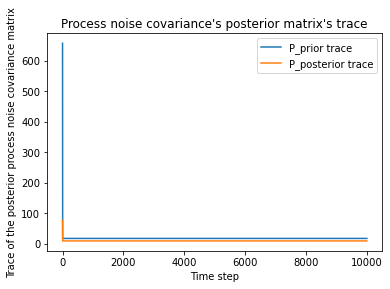

In [337]:
# 7. P_posterior and P_prior matrices' trace plots

plt.plot(range(10000),P_prior_plot, label='P_prior trace')
plt.title("Process noise covariance's prior matrix's trace")
plt.xlabel('Time step')
plt.ylabel('Trace of the prior process noise covariance matrix')
plt.legend()

plt.plot(range(10000),P_posterior_plot, label='P_posterior trace')
plt.title("Process noise covariance's posterior matrix's trace")
plt.xlabel('Time step')
plt.ylabel('Trace of the posterior process noise covariance matrix')
plt.legend()

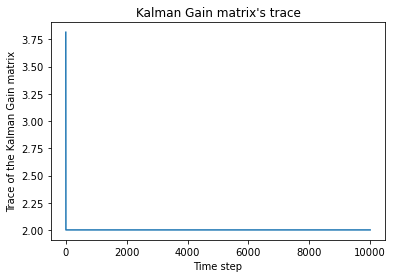

In [338]:
# 8. Kalman_Gain matrix's trace plot
Kalman_Gain_trace_plot = [Kalman_Gain_store[i] for i in range(10000)]

plt.plot(range(10000),Kalman_Gain_trace_plot)
plt.title("Kalman Gain matrix's trace")
plt.xlabel('Time step')
plt.ylabel('Trace of the Kalman Gain matrix')
plt.show()

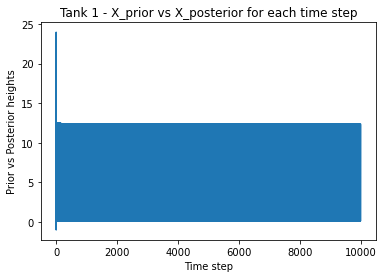

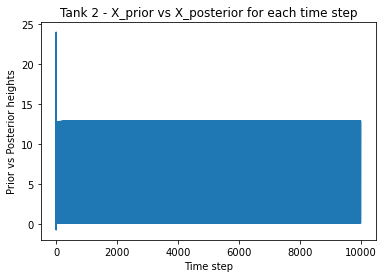

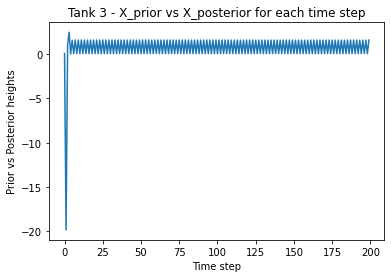

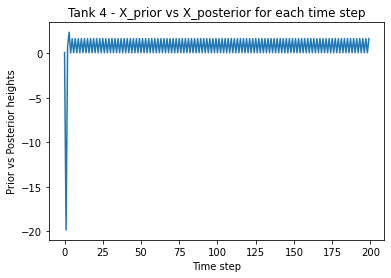

In [343]:
# 9. X_prior and X_posterior plot
X_pri_post_tank1 = []
X_pri_post_tank2 = []
X_pri_post_tank3 = []
X_pri_post_tank4 = []

for i in range(5000):
    X_pri_post_tank1.append(X_prior_tank1[i])
    X_pri_post_tank1.append(X_posterior_tank1[i])

plt.plot(range(10000), X_pri_post_tank1, label='X_prior vs X_posterior')
plt.title("Tank 1 - X_prior vs X_posterior for each time step")
plt.xlabel('Time step')
plt.ylabel('Prior vs Posterior heights')
plt.show()

for i in range(5000):
    X_pri_post_tank2.append(X_prior_tank2[i])
    X_pri_post_tank2.append(X_posterior_tank2[i])

plt.plot(range(10000), X_pri_post_tank2, label='X_prior vs X_posterior')
plt.title("Tank 2 - X_prior vs X_posterior for each time step")
plt.xlabel('Time step')
plt.ylabel('Prior vs Posterior heights')
plt.show()

for i in range(100):
    X_pri_post_tank3.append(X_prior_tank3[i])
    X_pri_post_tank3.append(X_posterior_tank3[i])

plt.plot(range(200), X_pri_post_tank3, label='X_prior vs X_posterior')
plt.title("Tank 3 - X_prior vs X_posterior for each time step")
plt.xlabel('Time step')
plt.ylabel('Prior vs Posterior heights')
plt.show()

for i in range(100):
    X_pri_post_tank4.append(X_prior_tank4[i])
    X_pri_post_tank4.append(X_posterior_tank4[i])

plt.plot(range(200), X_pri_post_tank4, label='X_prior vs X_posterior')
plt.title("Tank 4 - X_prior vs X_posterior for each time step")
plt.xlabel('Time step')
plt.ylabel('Prior vs Posterior heights')
plt.show()

# KF-1 Conclusions:
a. Estimated final tank heights after 10000 observations are: Tank 1 = 12.3247 cm, Tank 2 = 12.8342 cm, Tank 3 = 1.5971 cm, Tank 4 = 1.6294 cm

b. Observed final tank heights after 10000 observations are: Tank 1 = 12.26297 cm, Tank 2 = 12.78316 cm, Tank 3 = 1.63394 cm, Tank 4 = 1.40904 cm

# 2.) KF-2 Initializations

In [364]:
# Area of the tank using its diameter
A1 = 28
A2 = 32
A3 = 28
A4 = 32

# Area of the orifice using its diameter
a1 = 0.071
a2 = 0.057
a3 = 0.071
a4 = 0.057

# Time Constants
T1 = 62
T2 = 90
T3 = 23
T4 = 30

# Gammas
gamma1 = 0.7
gamma2 = 0.6

# Constant of proportionality for Voltage-Flow relationship
k1 = 3.33
k2 = 3.35

# Tank height measurement constant for the tanks 1 and 2 only
kc = 0.5

# Gravitation constant
g = 981

# Input Voltages
v1 = 3
v2 = 3


# A, B, H, U
A = np.array([[-1/T1, 0, A3/(A1*T3), 0], [0, -1/T2, 0, A4/(A2*T4)], [0, 0, -1/T3, 0], [0, 0, 0, -1/T4]])
B = np.array([[(gamma1*k1)/A1, 0], [0, (gamma2*k2)/A2], [0, (1-gamma2)*k2/A3], [(1-gamma1)*k1/A4, 0]])
H = np.array([[kc, 0, 0, 0], [0, kc, 0, 0]])
U = np.array([[v1, v2]]).T

# Lists to store
X_posterior_store = []
X_prior_store = []
P_posterior_store = []
P_prior_store = []
Kalman_Gain_store = []
Innovation_store = []
Residue_store = []

# Kalman Filter- Using height difference and voltage difference

In [365]:
# Some filter method specific initializations

# Initial state of the tank heights
h0 = np.array([[12.4, 12.7, 1.8, 1.4]]).T

#  X_post_0, P_post_0, Q, R, delta_t
X_posterior_0 = h0
P_posterior_0 = 1e5*np.eye(4)
Q = 1000*np.eye(4)
R = 0.001*np.eye(2)
delta_t = 0.1

# KF-2 estimation
for iteration in range(10000):
    
    # True voltage from the second record of measured heights excel file
    V_i = (H.dot(Z_true_np[iteration+1,:4].reshape(-1,1)))

    # Height prior calculation based on the IEEE paper
    X_prior = (A.dot(X_posterior_0 - h0) + B.dot(V_i-U))*delta_t
    # X_prior without h0 is the delta_height, hence getting the actual height by adding the previous measure height at each time step
    X_prior += h0
    # Updating the h0 for the next iteration already
    h0 = Z_true_np[iteration+1,:4].reshape(-1,1)
    # Calculating Process noise covariance matrix
    P_prior = ((A.dot(P_posterior_0)).dot(A.T) + Q)*(delta_t**2)
    #Calculating the Kalman Gain
    Kalman_Gain = (P_prior.dot(H.T)).dot((np.linalg.inv((H.dot(P_prior)).dot(H.T) + R)))
    # Estimating the output voltage for each time step
    V_true = H.dot(Z_true_np[iteration, :4].reshape(-1,1))
    # Calculating the Error between the true and the predicted output voltages
    Error = V_true - H.dot(X_prior)
    
    # Kalman height update step
    X_posterior = X_prior + Kalman_Gain.dot(Error)
    # Kalman process noise covariance update step
    P_posterior = P_prior - (Kalman_Gain.dot(H)).dot(P_prior)
    
    # Storing various values for plotting in lists
    X_posterior_store.append(X_posterior.tolist())
    P_posterior_store.append(np.trace(P_posterior))
    X_prior_store.append(X_prior.tolist())
    P_prior_store.append(np.trace(P_prior))
    Kalman_Gain_store.append(np.trace(Kalman_Gain))
    Innovation_store.append(Error.tolist())
    Residue_store.append((H.dot(Z_true_np[iteration, :4].reshape(-1,1)) - H.dot(X_posterior)).tolist())
    
    # updating the posteriors of X and P for the next time step in the for loop
    X_posterior_0 = X_posterior
    P_posterior_0 = P_posterior
    
    # Algorithm stopping condition
    Threshold = np.linalg.norm((X_prior - X_posterior), 2)
    if (Threshold <= .005):
        print('Exiting the loop...')
        break


# KF-2: Plots

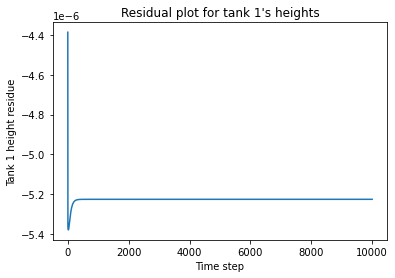

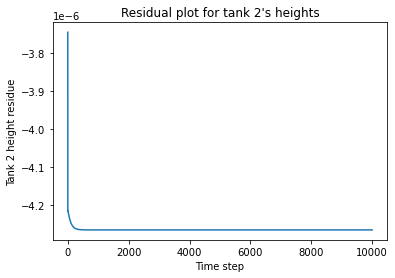

In [366]:
# 1. Residue plots
resid_h1 = [Residue_store[i][0][0] for i in range(10000)]
resid_h2 = [Residue_store[i][1][0] for i in range(10000)]

plt.plot(range(10000), resid_h1)
plt.title("Residual plot for tank 1's heights")
plt.xlabel('Time step')
plt.ylabel('Tank 1 height residue')
plt.show()
plt.plot(range(10000), resid_h2)
plt.title("Residual plot for tank 2's heights")
plt.xlabel('Time step')
plt.ylabel('Tank 2 height residue')
plt.show()

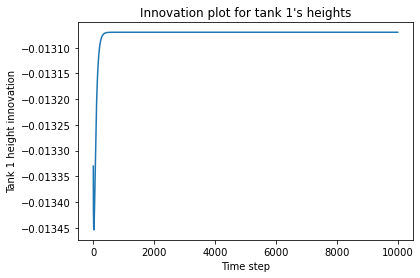

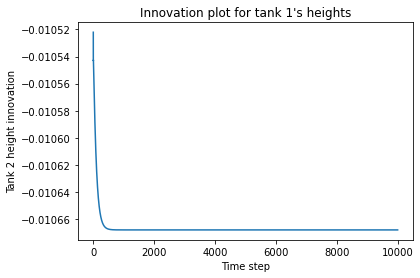

In [367]:
# 2. Innovation plots
innov_h1 = [Innovation_store[i][0][0] for i in range(10000)]
innov_h2 = [Innovation_store[i][1][0] for i in range(10000)]

plt.plot(range(10000), innov_h1)
plt.title("Innovation plot for tank 1's heights")
plt.xlabel('Time step')
plt.ylabel('Tank 1 height innovation')
plt.show()
plt.plot(range(10000), innov_h2)
plt.title("Innovation plot for tank 1's heights")
plt.xlabel('Time step')
plt.ylabel('Tank 2 height innovation')
plt.show()

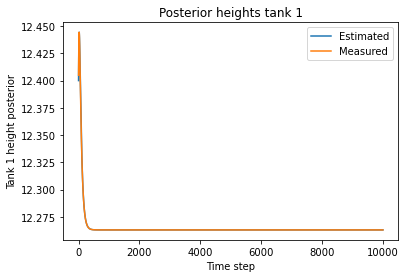

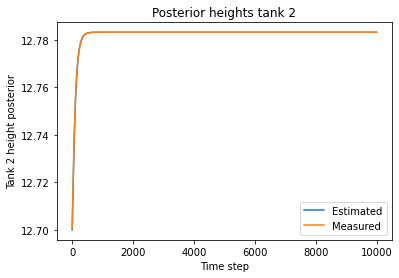

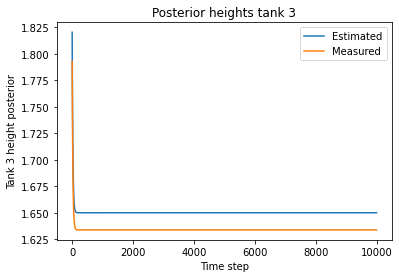

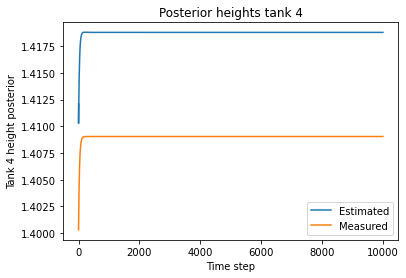

In [368]:
# 3. X_posterior plot
X_posterior_tank1 = [X_posterior_store[i][0][0] for i in range(10000)]
X_posterior_tank2 = [X_posterior_store[i][1][0] for i in range(10000)]
X_posterior_tank3 = [X_posterior_store[i][2][0] for i in range(10000)]
X_posterior_tank4 = [X_posterior_store[i][3][0] for i in range(10000)]

plt.plot(range(10000),X_posterior_tank1, label='Estimated')
plt.plot(range(10000), Z_true_np[1:,0], label='Measured')
plt.title('Posterior heights tank 1')
plt.xlabel('Time step')
plt.ylabel('Tank 1 height posterior')
plt.legend()
plt.show()

plt.plot(range(10000),X_posterior_tank2, label='Estimated')
plt.plot(range(10000), Z_true_np[1:,1], label='Measured')
plt.title('Posterior heights tank 2')
plt.xlabel('Time step')
plt.ylabel('Tank 2 height posterior')
plt.legend()
plt.show()

plt.plot(range(10000),X_posterior_tank3, label='Estimated')
plt.plot(range(10000), Z_true_np[1:,2], label='Measured')
plt.title('Posterior heights tank 3')
plt.xlabel('Time step')
plt.ylabel('Tank 3 height posterior')
plt.legend()
plt.show()

plt.plot(range(10000),X_posterior_tank4, label='Estimated')
plt.plot(range(10000), Z_true_np[1:,3], label='Measured')
plt.title('Posterior heights tank 4')
plt.xlabel('Time step')
plt.ylabel('Tank 4 height posterior')
plt.legend()
plt.show()

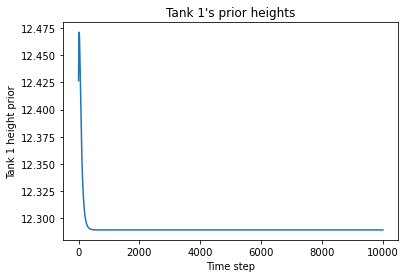

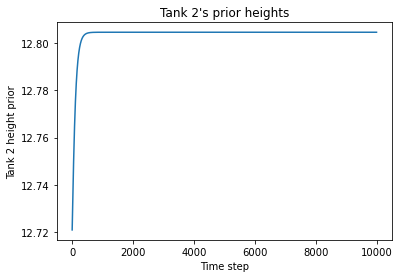

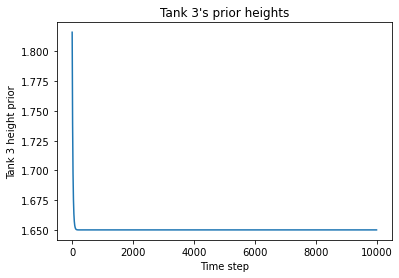

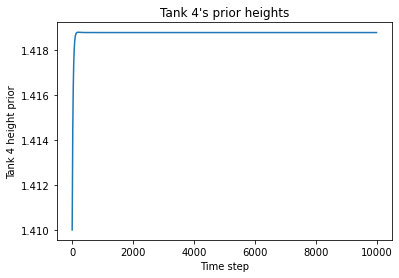

In [369]:
# 4. X_prior plot
X_prior_tank1 = [X_prior_store[i][0][0] for i in range(10000)]
X_prior_tank2 = [X_prior_store[i][1][0] for i in range(10000)]
X_prior_tank3 = [X_prior_store[i][2][0] for i in range(10000)]
X_prior_tank4 = [X_prior_store[i][3][0] for i in range(10000)]

plt.plot(range(10000),X_prior_tank1)
plt.title("Tank 1's prior heights")
plt.xlabel('Time step')
plt.ylabel('Tank 1 height prior')
plt.show()
plt.plot(range(10000),X_prior_tank2)
plt.title("Tank 2's prior heights")
plt.xlabel('Time step')
plt.ylabel('Tank 2 height prior')
plt.show()
plt.plot(range(10000),X_prior_tank3)
plt.title("Tank 3's prior heights")
plt.xlabel('Time step')
plt.ylabel('Tank 3 height prior')
plt.show()
plt.plot(range(10000),X_prior_tank4)
plt.title("Tank 4's prior heights")
plt.xlabel('Time step')
plt.ylabel('Tank 4 height prior')
plt.show()

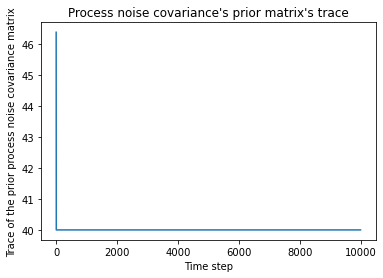

In [370]:
# 5. P_prior matrix's trace plot
P_prior_plot = [P_prior_store[i] for i in range(10000)]

plt.plot(range(10000),P_prior_plot)
plt.title("Process noise covariance's prior matrix's trace")
plt.xlabel('Time step')
plt.ylabel('Trace of the prior process noise covariance matrix')
plt.show()

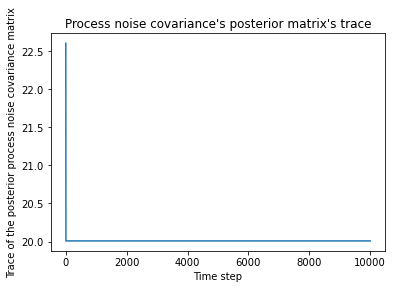

In [371]:
# 6. P_posterior matrix's trace plot
P_posterior_plot = [P_posterior_store[i] for i in range(10000)]

plt.plot(range(10000),P_posterior_plot)
plt.title("Process noise covariance's posterior matrix's trace")
plt.xlabel('Time step')
plt.ylabel('Trace of the posterior process noise covariance matrix')
plt.show()

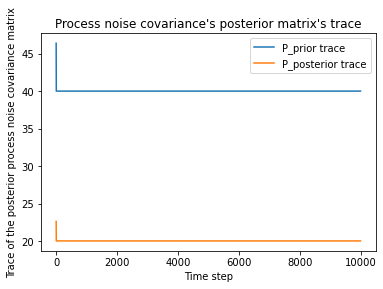

In [372]:
# 7. P_posterior and P_prior matrices' trace plots

plt.plot(range(10000),P_prior_plot, label='P_prior trace')
plt.title("Process noise covariance's prior matrix's trace")
plt.xlabel('Time step')
plt.ylabel('Trace of the prior process noise covariance matrix')
plt.legend()

plt.plot(range(10000),P_posterior_plot, label='P_posterior trace')
plt.title("Process noise covariance's posterior matrix's trace")
plt.xlabel('Time step')
plt.ylabel('Trace of the posterior process noise covariance matrix')
plt.legend()

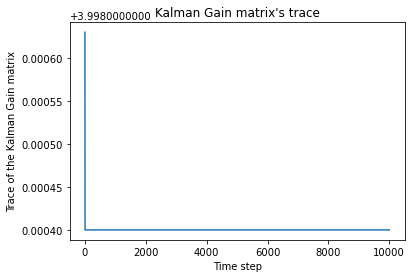

In [373]:
# 8. Kalman_Gain matrix's trace plot
Kalman_Gain_trace_plot = [Kalman_Gain_store[i] for i in range(10000)]

plt.plot(range(10000),Kalman_Gain_trace_plot)
plt.title("Kalman Gain matrix's trace")
plt.xlabel('Time step')
plt.ylabel('Trace of the Kalman Gain matrix')
plt.show()

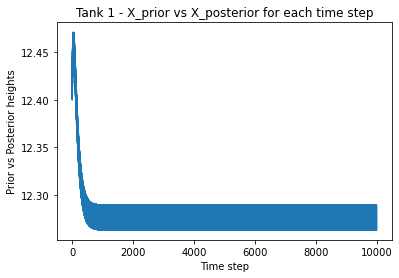

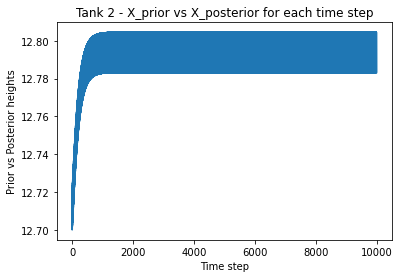

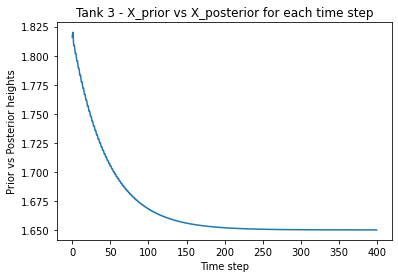

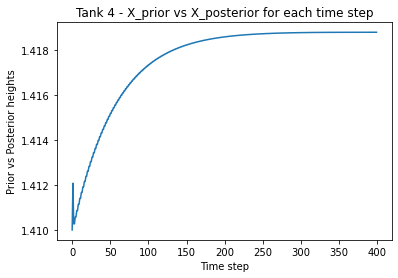

In [374]:
# 9. X_prior and X_posterior plot
X_pri_post_tank1 = []
X_pri_post_tank2 = []
X_pri_post_tank3 = []
X_pri_post_tank4 = []

for i in range(5000):
    X_pri_post_tank1.append(X_prior_tank1[i])
    X_pri_post_tank1.append(X_posterior_tank1[i])

plt.plot(range(10000), X_pri_post_tank1, label='X_prior vs X_posterior')
plt.title("Tank 1 - X_prior vs X_posterior for each time step")
plt.xlabel('Time step')
plt.ylabel('Prior vs Posterior heights')
plt.show()

for i in range(5000):
    X_pri_post_tank2.append(X_prior_tank2[i])
    X_pri_post_tank2.append(X_posterior_tank2[i])

plt.plot(range(10000), X_pri_post_tank2, label='X_prior vs X_posterior')
plt.title("Tank 2 - X_prior vs X_posterior for each time step")
plt.xlabel('Time step')
plt.ylabel('Prior vs Posterior heights')
plt.show()

for i in range(200):
    X_pri_post_tank3.append(X_prior_tank3[i])
    X_pri_post_tank3.append(X_posterior_tank3[i])

plt.plot(range(400), X_pri_post_tank3, label='X_prior vs X_posterior')
plt.title("Tank 3 - X_prior vs X_posterior for each time step")
plt.xlabel('Time step')
plt.ylabel('Prior vs Posterior heights')
plt.show()

for i in range(200):
    X_pri_post_tank4.append(X_prior_tank4[i])
    X_pri_post_tank4.append(X_posterior_tank4[i])

plt.plot(range(400), X_pri_post_tank4, label='X_prior vs X_posterior')
plt.title("Tank 4 - X_prior vs X_posterior for each time step")
plt.xlabel('Time step')
plt.ylabel('Prior vs Posterior heights')
plt.show()

# KF-2 Conclusions:
a. Estimated final tank heights after 10000 observations are: Tank 1 = 12.26297 cm, Tank 2 = 12.78316 cm, Tank 3 = 1.65010 cm, Tank 4 = 1.41878 cm

b. Observed final tank heights after 10000 observations are: Tank 1 = 12.26297 cm, Tank 2 = 12.78316 cm, Tank 3 = 1.63394 cm, Tank 4 = 1.40904 cm

# Comparison KF-1 vs KF-2
1. KF-2's estimate is much closer to the observed height measurements than KF-1's.
2. KF-2 algorithm uses the X_i = h_i - h_i0 and U_i = v_i - v_i0 as the process state and the control input vectors so the estimates are much closer to the observed tank heights after 10000 time steps/iterations.
3. KF-1 algorithm uses x as vector of ones which is far away from the tank height observations.
4. Both the implementations are equally efficient!

In [375]:
#_______________________________________________________END OF NOTEBOOK_________________________________________________________